# checking GPU

In [1]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("GPU is not available. Using CPU.")

Using Tesla T4


In [2]:
import torch

# Check CUDA availability
if torch.cuda.is_available():
    device = torch.device("cuda")  # Select the default GPU
    tensor_on_cpu = torch.randn(3, 3)
    tensor_on_gpu = tensor_on_cpu.to(device)

    # Perform some computation on the GPU
    result = tensor_on_gpu + 1

    print("Tensor on GPU:", tensor_on_gpu)
    print("Result on GPU:", result)
else:
    print("CUDA is not available on your system.")

Tensor on GPU: tensor([[ 0.8709, -0.6072,  0.1630],
        [-0.5406, -2.0915, -0.3052],
        [-0.9133,  0.9833, -1.2237]], device='cuda:0')
Result on GPU: tensor([[ 1.8709,  0.3928,  1.1630],
        [ 0.4594, -1.0915,  0.6948],
        [ 0.0867,  1.9833, -0.2237]], device='cuda:0')


# Importing All the Libraries

In [3]:
import os
# for deep learning with PyTorch.
import torch
# for defining neural network layers and modules.
import torch.nn as nn
# for various optimization algorithms.
import torch.optim as optim
import torch.nn.functional as F
# for dataset management and data loading.
from torch.utils.data import Dataset, DataLoader
# for data preprocessing and augmentations for image data.
from torchvision import transforms
# for working with images.
from PIL import Image
# for numerical operations and array manipulation.
import numpy as np
# for serializing and deserializing Python objects.
import pickle as pkl
# for creating plots and visualizations.
import matplotlib.pyplot as plt
# for advanced plotting and grid layouts.
from mpl_toolkits.axes_grid1 import ImageGrid


# Dataset Access

In [4]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, img_dir):
        # Combine the base dataset path with the provided 'img_dir' to get the full directory path.
        img_dir = BASE_DATASET_PATH + "/" + img_dir + "/"

        # List all the file names in the 'img_dir'.
        path_list = os.listdir(img_dir)

        # Get the absolute path of the 'img_dir'.
        abspath = os.path.abspath(img_dir)

        # Store the 'img_dir', a list of image file paths, and a data transformation pipeline.
        self.img_dir = img_dir
        self.img_list = [os.path.join(abspath, path) for path in path_list]

        # Define a series of image transformations using 'transforms.Compose'.
        self.transform = transforms.Compose([
            transforms.Resize(IMG_SIZE),  # Resize the image to a specific size.
            transforms.ToTensor(),  # Convert the image to a PyTorch tensor.
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize the image to have values in the range [-1, 1].
        ])

    def __len__(self):
        # Return the total number of images in the dataset.
        return len(self.img_list)

    def __getitem__(self, idx):
        # Get the file path of the image at the specified index.
        path = self.img_list[idx]

        # Open the image file, convert it to RGB, and store it as 'img'.
        img = Image.open(path).convert('RGB')

        # Apply the defined transformation to the image and convert it to a tensor.
        img_tensor = self.transform(img)

        # Return the transformed image tensor.
        return img_tensor


# Discriminator Class

In [5]:
# This Discriminator class defines the architecture of a typical  discriminator used in GANs
# It takes an input image (3 channels for RGB),
# processes it through several convolutional layers with leaky ReLU activation functions, and
# f(x)=max(0.01*x , x) -> leaky ReLU
# outputs a single scalar value representing the discriminator's assessment of the input image.
# The instance normalization and architectural choices are common in GANs for image generation tasks.
class Discriminator(nn.Module):
    def __init__(self, conv_dim=32):
        super(Discriminator, self).__init__()

        # Define the architecture of the discriminator using a series of convolutional layers.
        self.main = nn.Sequential(
            # First convolutional layer: 3 input channels (for RGB images) to 'conv_dim' output channels.
            nn.Conv2d(3, conv_dim, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),  # Leaky ReLU activation function for non-linearity.

            # Second convolutional layer: 'conv_dim' input channels to 'conv_dim*2' output channels.
            nn.Conv2d(conv_dim, conv_dim * 2, 4, stride=2, padding=1),
            nn.InstanceNorm2d(conv_dim * 2),  # Instance normalization for better training stability.
            nn.LeakyReLU(0.2, inplace=True),

            # Third convolutional layer: 'conv_dim*2' input channels to 'conv_dim*4' output channels.
            nn.Conv2d(conv_dim * 2, conv_dim * 4, 4, stride=2, padding=1),
            nn.InstanceNorm2d(conv_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # Fourth convolutional layer: 'conv_dim*4' input channels to 'conv_dim*8' output channels.
            nn.Conv2d(conv_dim * 4, conv_dim * 8, 4, padding=1),
            nn.InstanceNorm2d(conv_dim * 8),
            nn.LeakyReLU(0.2, inplace=True),

            # Final convolutional layer: 'conv_dim*8' input channels to a single output channel.
            nn.Conv2d(conv_dim * 8, 1, 4, padding=1),
        )

    def forward(self, x):
        # Pass the input 'x' through the defined layers in the 'main' sequential module.
        x = self.main(x)

        # Apply average pooling to reduce spatial dimensions to 1x1.
        x = F.avg_pool2d(x, x.size()[2:])

        # Flatten the tensor to prepare it for the final classification layer.
        x = torch.flatten(x, 1)

        # Return the output tensor representing the discriminator's classification score.
        return x


# ResidualBlock Class

In [6]:
#  ResidualBlock is a neural network component that
#  learns to capture and reuse important features from the input
#   by adding the original input to the processed output, enhancing
#   gradient flow and facilitating deeper network training in architectures like ResNet.
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()

        # Define a residual block using a sequence of convolutional layers.
        self.main = nn.Sequential(
            nn.ReflectionPad2d(1),  # Reflective padding to maintain spatial dimensions.
            nn.Conv2d(in_channels, in_channels, 3),  # Convolution with the same number of input and output channels.
            nn.InstanceNorm2d(in_channels),  # Instance normalization for improved training stability.
            nn.ReLU(inplace=True),  # ReLU activation function for non-linearity.

            nn.ReflectionPad2d(1),  # Reflective padding again.
            nn.Conv2d(in_channels, in_channels, 3),  # Another convolution with the same number of channels.
            nn.InstanceNorm2d(in_channels)  # Instance normalization.
        )

    def forward(self, x):
        # The forward pass of the residual block.
        # It takes an input 'x', passes it through the 'main' sequential module, and adds the original input.
        return x + self.main(x)


# Generator Class

In [7]:
# a Generator class that inherits from nn.Module.
class Generator(nn.Module):
    def __init__(self, conv_dim=64, n_res_block=9):
        super(Generator, self).__init__()

        # Create a sequence of layers for the generator network using nn.Sequential.
        self.main = nn.Sequential(
            # Reflection padding to handle the boundary of the input image.
            nn.ReflectionPad2d(3),

            # Initial convolution layer, input channels=3 (RGB), output channels=conv_dim, kernel size=7.
            nn.Conv2d(3, conv_dim, 7),

            # Instance normalization for the first convolution output.
            nn.InstanceNorm2d(64),

            # ReLU activation function.
            nn.ReLU(inplace=True),

            # Down-sampling layer using convolution, increasing the number of channels.
            nn.Conv2d(conv_dim, conv_dim*2, 3, stride=2, padding=1),

            # Instance normalization.
            nn.InstanceNorm2d(conv_dim*2),

            # ReLU activation.
            nn.ReLU(inplace=True),

            # Another down-sampling layer.
            nn.Conv2d(conv_dim*2, conv_dim*4, 3, stride=2, padding=1),

            # Instance normalization.
            nn.InstanceNorm2d(conv_dim*4),

            # ReLU activation.
            nn.ReLU(inplace=True),

            # Stack multiple residual blocks (n_res_block times).
            ResidualBlock(conv_dim*4),
            ResidualBlock(conv_dim*4),
            ResidualBlock(conv_dim*4),
            ResidualBlock(conv_dim*4),
            ResidualBlock(conv_dim*4),
            ResidualBlock(conv_dim*4),
            ResidualBlock(conv_dim*4),
            ResidualBlock(conv_dim*4),
            ResidualBlock(conv_dim*4),

            # Up-sampling layer using transposed convolution.
            nn.ConvTranspose2d(conv_dim*4, conv_dim*2, 3, stride=2, padding=1, output_padding=1),

            # Instance normalization.
            nn.InstanceNorm2d(conv_dim*2),

            # ReLU activation.
            nn.ReLU(inplace=True),

            # Another up-sampling layer.
            nn.ConvTranspose2d(conv_dim*2, conv_dim, 3, stride=2, padding=1, output_padding=1),

            # Instance normalization.
            nn.InstanceNorm2d(conv_dim),

            # ReLU activation.
            nn.ReLU(inplace=True),

            # Reflection padding to handle the boundary of the output image.
            nn.ReflectionPad2d(3),

            # Final convolution layer to generate the output image, with 3 output channels (RGB), kernel size=7.
            nn.Conv2d(conv_dim, 3, 7),

            # Hyperbolic tangent (Tanh) activation to ensure output pixel values are in the range [-1, 1].
            nn.Tanh()
        )

    def forward(self, x):
        # Pass input through the defined layers in the network.
        return self.main(x)


# CycleGAN Class

In [8]:
# Define a CycleGAN class for training a CycleGAN model.
class CycleGAN:
    def __init__(self, g_conv_dim=64, d_conv_dim=64, n_res_block=6):
        # Check if a GPU is available and set the device accordingly.
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device("cpu")

        # Create generator networks for both directions (X to Y and Y to X) and move them to the device.
        self.G_XtoY = Generator(conv_dim=g_conv_dim, n_res_block=n_res_block).to(self.device)
        self.G_YtoX = Generator(conv_dim=g_conv_dim, n_res_block=n_res_block).to(self.device)

        # Create discriminator networks for both domains and move them to the device.
        self.D_X = Discriminator(conv_dim=d_conv_dim).to(self.device)
        self.D_Y = Discriminator(conv_dim=d_conv_dim).to(self.device)

        print(f"Models running on {self.device}")

    # Function to load a model (currently not used in the code).
    def load_model(self, filename):
        save_filename = os.path.splitext(os.path.basename(filename))[0] + '.pt'
        return torch.load(save_filename)

    # Define a mean squared error loss for real samples.
    def real_mse_loss(self, D_out):
        return torch.mean((D_out-1)**2)

    # Define a mean squared error loss for fake samples.
    def fake_mse_loss(self, D_out):
        return torch.mean(D_out**2)

    # Define a cycle consistency loss between real and reconstructed images.
    def cycle_consistency_loss(self, real_img, reconstructed_img, lambda_weight):
        reconstr_loss = torch.mean(torch.abs(real_img - reconstructed_img))
        return lambda_weight * reconstr_loss

    # Training function for the generator.
    def train_generator(self, optimizers, images_x, images_y):
        # Generator Y to X
        optimizers["g_optim"].zero_grad()

        # Generate fake images in the X domain from real images in the Y domain.
        fake_images_x = self.G_YtoX(images_y)

        # Calculate the discriminator loss for the generated images in the X domain.
        d_real_x = self.D_X(fake_images_x)
        g_YtoX_loss = self.real_mse_loss(d_real_x)

        # Reconstruct images in the Y domain from the generated X domain images.
        recon_y = self.G_XtoY(fake_images_x)

        # Calculate the cycle consistency loss for the Y domain.
        recon_y_loss = self.cycle_consistency_loss(images_y, recon_y, lambda_weight=10)

        # Generator X to Y
        fake_images_y = self.G_XtoY(images_x)
        d_real_y = self.D_Y(fake_images_y)
        g_XtoY_loss = self.real_mse_loss(d_real_y)

        recon_x = self.G_YtoX(fake_images_y)
        recon_x_loss = self.cycle_consistency_loss(images_x, recon_x, lambda_weight=10)

        # Calculate the total generator loss and backpropagate.
        g_total_loss = g_YtoX_loss + g_XtoY_loss + recon_y_loss + recon_x_loss
        g_total_loss.backward()
        optimizers["g_optim"].step()

        return g_total_loss.item()

    # Training function for the discriminator.
    def train_discriminator(self, optimizers, images_x, images_y):
        # Discriminator X
        optimizers["d_x_optim"].zero_grad()

        # Calculate the discriminator loss for real X domain images.
        d_real_x = self.D_X(images_x)
        d_real_loss_x = self.real_mse_loss(d_real_x)

        # Generate fake X domain images from real Y domain images.
        fake_images_x = self.G_YtoX(images_y)

        # Calculate the discriminator loss for the generated X domain images.
        d_fake_x = self.D_X(fake_images_x)
        d_fake_loss_x = self.fake_mse_loss(d_fake_x)

        # Combine real and fake losses for the X domain and backpropagate.
        d_x_loss = d_real_loss_x + d_fake_loss_x
        d_x_loss.backward()
        optimizers["d_x_optim"].step()

        # Discriminator Y
        optimizers["d_y_optim"].zero_grad()

        # Calculate the discriminator loss for real Y domain images.
        d_real_y = self.D_Y(images_y)
        d_real_loss_y = self.real_mse_loss(d_real_y)

        # Generate fake Y domain images from real X domain images.
        fake_images_y = self.G_XtoY(images_x)

        # Calculate the discriminator loss for the generated Y domain images.
        d_fake_y = self.D_Y(fake_images_y)
        d_fake_loss_y = self.fake_mse_loss(d_fake_y)

        # Combine real and fake losses for the Y domain and backpropagate.
        d_y_loss = d_real_loss_y + d_fake_loss_y
        d_y_loss.backward()
        optimizers["d_y_optim"].step()

        return d_x_loss.item(), d_y_loss.item()

    # Main training function for the CycleGAN.
    def train(self, optimizers, data_loader_x, data_loader_y, print_every=10, sample_every=100):
        losses = []
        g_total_loss_min = np.Inf

        # Get fixed images for visualization during training.
        fixed_x = next(iter(data_loader_x))[1].to(self.device)
        fixed_y = next(iter(data_loader_y))[1].to(self.device)

        print(f'Running on {self.device}')

        for epoch in range(EPOCHS):
            for (images_x, images_y) in zip(data_loader_x, data_loader_y):
                images_x, images_y = images_x.to(self.device), images_y.to(self.device)

                g_total_loss = self.train_generator(optimizers, images_x, images_y)
                d_x_loss, d_y_loss = self.train_discriminator(optimizers, images_x, images_y)

            if epoch % print_every == 0:
                losses.append((d_x_loss, d_y_loss, g_total_loss))
                print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f}'
                .format(
                    epoch,
                    EPOCHS,
                    d_x_loss,
                    d_y_loss,
                    g_total_loss
                ))

            if g_total_loss < g_total_loss_min:
                g_total_loss_min = g_total_loss

                # Save the best models.
                torch.save(self.G_XtoY.state_dict(), "G_X2Y")
                torch.save(self.G_YtoX.state_dict(), "G_Y2X")
                torch.save(self.D_X.state_dict(), "D_X")
                torch.save(self.D_Y.state_dict(), "D_Y")
                print("Models Saved")

        return losses


# Config

In [9]:
# Base path to the dataset directory.
BASE_DATASET_PATH = "../input/dataset"
# Name of the dataset for the first domain (e.g., images of type A).
X_DATASET = "trainA"
# Name of the dataset for the second domain (e.g., images of type B).
Y_DATASET = "trainB"
# Batch size for training data. Number of samples processed in each iteration.
BATCH_SIZE = 32
# Number of data loading workers. Controls parallel data loading for improved efficiency.
N_WORKERS = 0
# Desired image size for training. Images will be resized or cropped to this size.
IMG_SIZE = 128
# Learning rate for the optimizer. Determines the step size during weight updates.
LR = 0.0002
# First moment (momentum) for the optimizer's exponential moving average of gradients.
BETA1 = 0.5
# Second moment for the optimizer's exponential moving average of gradients.
BETA2 = 0.999
# Number of training epochs. Defines how many times the dataset will be processed.
EPOCHS = 100


# Train

In [10]:
# Dataset
x_dataset = Dataset(X_DATASET)
y_dataset = Dataset(Y_DATASET)

data_loader_x = DataLoader(x_dataset, BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)
data_loader_y = DataLoader(y_dataset, BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)

# Model
cycleGan = CycleGAN()

# Oprimizer
g_params = list(cycleGan.G_XtoY.parameters()) + list(cycleGan.G_YtoX.parameters())

optimizers = {
    "g_optim": optim.Adam(g_params, LR, [BETA1, BETA2]),
    "d_x_optim": optim.Adam(cycleGan.D_X.parameters(), LR, [BETA1, BETA2]),
    "d_y_optim": optim.Adam(cycleGan.D_Y.parameters(), LR, [BETA1, BETA2])
}

# Train
losses = cycleGan.train(optimizers, data_loader_x, data_loader_y, print_every=1)

Models running on cuda
Running on cuda
Epoch [    0/  100] | d_X_loss: 0.3350 | d_Y_loss: 0.5562 | g_total_loss: 8.1416
Models Saved
Epoch [    1/  100] | d_X_loss: 0.3622 | d_Y_loss: 0.3307 | g_total_loss: 7.1427
Models Saved
Epoch [    2/  100] | d_X_loss: 0.3851 | d_Y_loss: 0.6286 | g_total_loss: 5.5007
Models Saved
Epoch [    3/  100] | d_X_loss: 0.3278 | d_Y_loss: 0.2284 | g_total_loss: 6.5727
Epoch [    4/  100] | d_X_loss: 0.4076 | d_Y_loss: 0.4229 | g_total_loss: 4.8776
Models Saved
Epoch [    5/  100] | d_X_loss: 0.2076 | d_Y_loss: 0.3159 | g_total_loss: 4.5913
Models Saved
Epoch [    6/  100] | d_X_loss: 0.4064 | d_Y_loss: 0.2014 | g_total_loss: 5.0465
Epoch [    7/  100] | d_X_loss: 0.2849 | d_Y_loss: 0.2226 | g_total_loss: 6.4087
Epoch [    8/  100] | d_X_loss: 0.2702 | d_Y_loss: 0.3855 | g_total_loss: 6.6063
Epoch [    9/  100] | d_X_loss: 0.3206 | d_Y_loss: 0.3730 | g_total_loss: 4.8018
Epoch [   10/  100] | d_X_loss: 0.4072 | d_Y_loss: 0.4213 | g_total_loss: 4.8393
Epoch

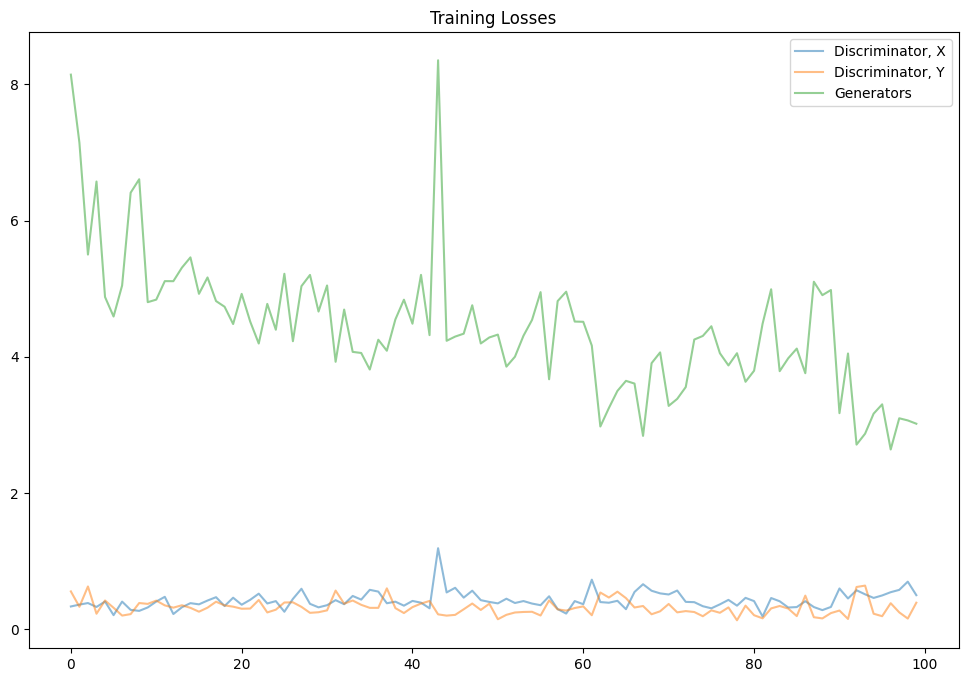

In [11]:
# Plot
fig, ax = plt.subplots(figsize=(12,8))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator, X', alpha=0.5)
plt.plot(losses.T[1], label='Discriminator, Y', alpha=0.5)
plt.plot(losses.T[2], label='Generators', alpha=0.5)
plt.title("Training Losses")
plt.legend()
plt.show()

In [12]:
# Test Dataset
x_dataset = Dataset("testA")
y_dataset = Dataset("testB")

data_loader_x = DataLoader(x_dataset, BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)
data_loader_y = DataLoader(y_dataset, BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)

samples = []

for i in range(6):
    fixed_x = next(iter(data_loader_x))[i].to(cycleGan.device)
    fake_y = cycleGan.G_XtoY(torch.unsqueeze(fixed_x, dim=0))
    samples.extend([fixed_x, torch.squeeze(fake_y, 0)])

# Test Results

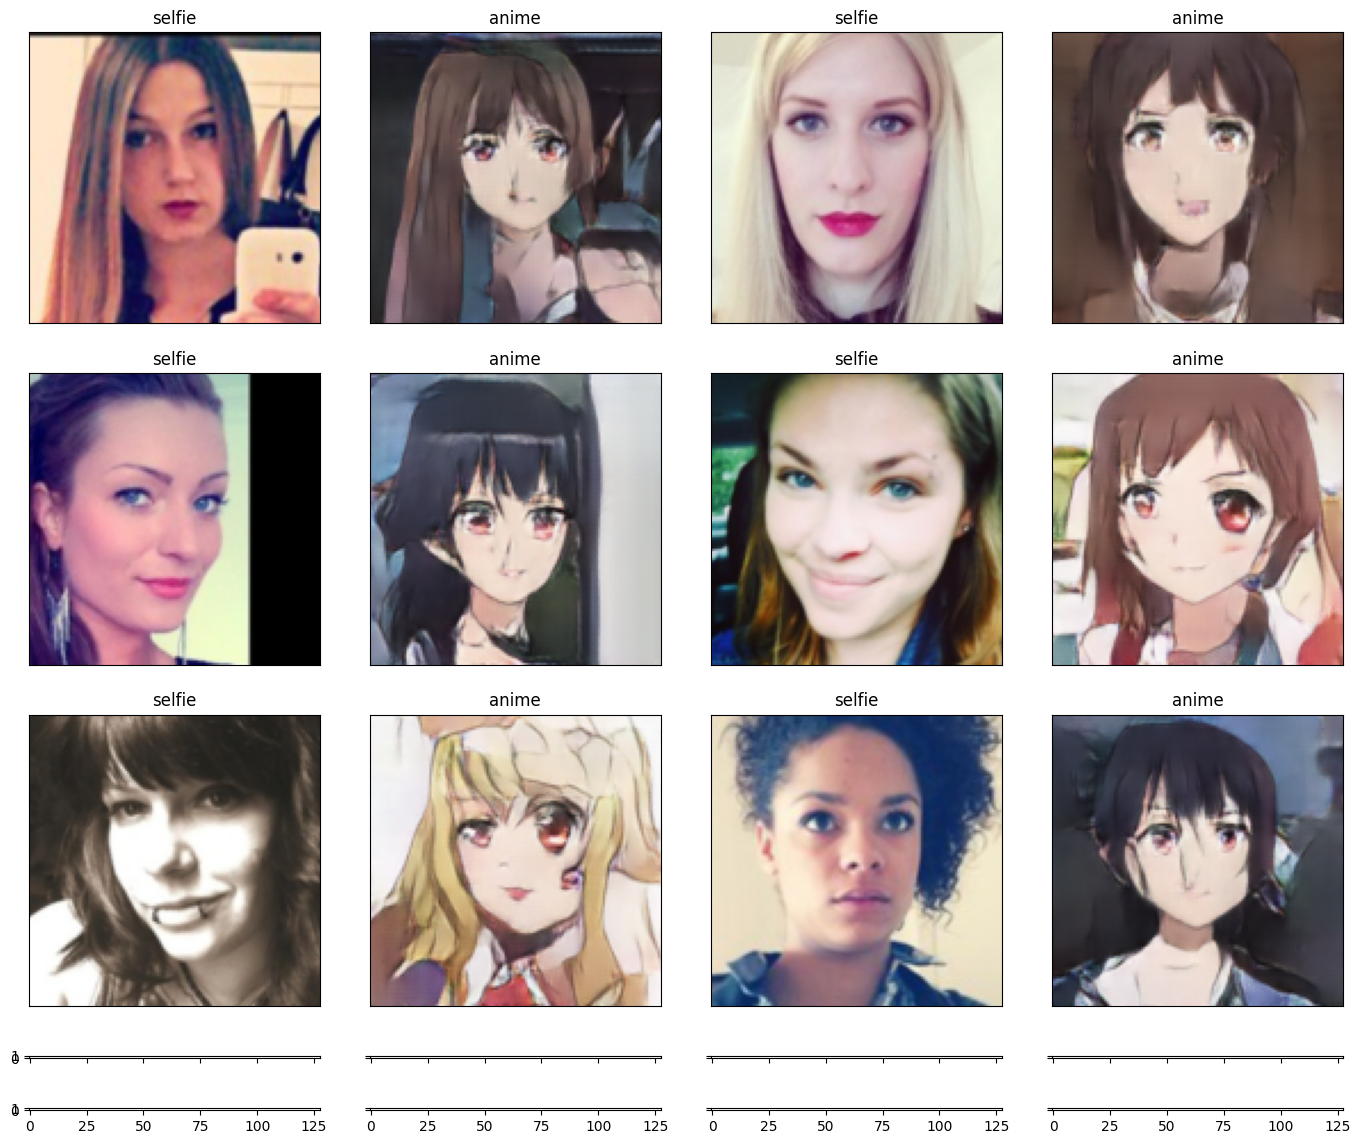

In [13]:
fig = plt.figure(figsize=(18, 14))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 4), axes_pad=0.5)


for i, (ax, im) in enumerate(zip(grid, samples)):
    _, w, h = im.size()
    im = im.detach().cpu().numpy()
    im = np.transpose(im, (1, 2, 0))

    im = ((im +1)*255 / (2)).astype(np.uint8)
    ax.imshow(im.reshape((w,h,3)))

    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    if i%2 == 0: title = "selfie"
    else: title = "anime"

    ax.set_title(title)

plt.show()